In [3]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import backend as K
K.set_image_data_format('channels_last')
from keras_applications import imagenet_utils as utils
from keras.layers import Lambda

import PIL.Image
#}

In [4]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
#from torch import cuda
#assert cuda.is_available()
#assert cuda.device_count() > 0
#print(cuda.get_device_name(cuda.current_device()))


In [5]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [6]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = utils.preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [7]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [10]:
#Resnet 169 models for Keras.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np


backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


BASE_WEIGHTS_PATH = (
    'https://github.com/keras-team/keras-applications/'
    'releases/download/resnet/')
WEIGHTS_HASHES = {
    'resnet50': ('2cb95161c43110f7111970584f804107',
                 '4d473c1dd8becc155b73f8504c6f6626'),
    'resnet101': ('f1aeb4b969a6efcfb50fad2f0c20cfc5',
                  '88cf7a10940856eca736dc7b7e228a21'),
    'resnet152': ('100835be76be38e30d865e96f2aaae62',
                  'ee4c566cf9a93f14d82f913c2dc6dd0c'),
    'resnet50v2': ('3ef43a0b657b3be2300d5770ece849e0',
                   'fac2f116257151a9d068a22e544a4917'),
    'resnet101v2': ('6343647c601c52e1368623803854d971',
                    'c0ed64b8031c3730f411d2eb4eea35b5'),
    'resnet152v2': ('a49b44d1979771252814e80f8ec446f9',
                    'ed17cf2e0169df9d443503ef94b23b33'),
    'resnext50': ('67a5b30d522ed92f75a1f16eef299d1a',
                  '62527c363bdd9ec598bed41947b379fc'),
    'resnext101': ('34fb605428fcc7aa4d62f44404c11509',
                   '0f678c91647380debd923963594981b3')
}

def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None, lambda_mask = None, input_size = None):
    """A residual block.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.

    # Returns
        Output tensor for the residual block.
    """
    global start_index, end_index, debug
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    #print(input_size, filters)
    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,name=name + '_0_conv')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (input_size* input_size* filters * 4)
            if debug:
                print(name + '_0_conv',start_index,end_index)
            shortcut_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 4)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut_mask = Lambda(lambda z: z * shortcut_mask)(shortcut)
        #################
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (input_size* input_size* filters * 4)
            if debug:
                print(name + '_0_bn',start_index,end_index)
            shortcut_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 4)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut_mask = Lambda(lambda z: z * shortcut_mask)(shortcut)
        #################
    else:
        shortcut = x
    

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_1_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_1_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
   #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_2_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_2_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters) * 4)
        if debug:
            print(name + '_3_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters * 4)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_3_bn')(x)

    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters) * 4)
        if debug:
            print(name + '_3_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters * 4)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x


def stack1(x, filters, blocks, stride1=2, name=None, lambda_mask=None, input_size = None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1', lambda_mask=lambda_mask, input_size = input_size)
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i), lambda_mask=lambda_mask, input_size = input_size)
    return x


def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.

    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x


def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None,lambda_mask=None, input_size = None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,use_bias=False, name=name + '_0_conv')(x)
        if lambda_mask is not None:
            shortcut_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters * 2))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 2)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut_mask = Lambda(lambda z: z * shortcut_mask)(shortcut)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_0_bn')(shortcut)
        if lambda_mask is not None:
            shortcut_mask  = np.reshape(lambda_mask[3211264:6422528], (filters//2, filters//2, filters * 2))
        else:
            shortcut_mask = np.ones(shape=((filters//2, filters//2, filters * 2)))

        shortcut_mask  = backend.variable(shortcut_mask)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,use_bias=False, name=name + '_2_conv')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters // 2)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,kernel_initializer={'class_name': 'Constant','config': {'value': kernel}},name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1, use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x


def stack3(x, filters, blocks, stride1=2, groups=32, name=None, lambda_mask=None, input_size = None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1', lambda_mask=lambda_mask, input_size = input_size)
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i), lambda_mask=lambda_mask, input_size = input_size)
    return x


def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           lambda_mask = None,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.

    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.

    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils, debug
    debug =False
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils


    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    
    global start_index, end_index
    start_index = 0
    end_index = 112*112*64
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)
    
    #################
    if lambda_mask is not None:
        if debug:
            print('conv1_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (112, 112, 64))
    else:
        x_mask = np.ones(shape=((112, 112, 64)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + 112*112*64 
            if debug:
                print('conv1_bn',start_index,end_index)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (112, 112, 64))
        else:
            x_mask = np.ones(shape=((112, 112, 64)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x, lambda_mask=lambda_mask)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)
        

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)
    #for layer in model.layers:
    #    print(layer.name,layer.output_shape)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,BASE_WEIGHTS_PATH + file_name,cache_subdir='models',file_hash=file_hash)
        by_name = True
        #by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model


def ResNet50(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNet101(include_top=True, weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,lambda_mask = None,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2',  lambda_mask=lambda_mask, input_size=56)
        x = stack1(x, 128, 4, name='conv3',  lambda_mask=lambda_mask, input_size=28)
        x = stack1(x, 256, 23, name='conv4',  lambda_mask=lambda_mask, input_size=14)
        x = stack1(x, 512, 3, name='conv5',  lambda_mask=lambda_mask, input_size=7)
        return x
    return ResNet(stack_fn, False, True, 'resnet101', include_top, weights,input_tensor, input_shape,pooling, classes, lambda_mask,**kwargs)


def ResNet152(include_top=True,weights='imagenet', input_tensor=None, input_shape=None,pooling=None,classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',include_top, weights, input_tensor, input_shape, pooling, classes,**kwargs)


def ResNet50V2(include_top=True, weights='imagenet',input_tensor=None, input_shape=None,pooling=None, classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNet101V2(include_top=True, weights='imagenet',input_tensor=None,input_shape=None, pooling=None,classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2', include_top, weights,input_tensor, input_shape, pooling, classes, **kwargs)


def ResNet152V2(include_top=True,weights='imagenet',input_tensor=None, input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2', include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNeXt50(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',include_top, weights,input_tensor, input_shape,pooling, classes, **kwargs)


def ResNeXt101(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,lambda_mask = None,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack3(x, 128, 3, stride1=1, name='conv2',  lambda_mask=lambda_mask, input_size=56)
        x = stack3(x, 256, 4, name='conv3',  lambda_mask=lambda_mask, input_size=28)
        x = stack3(x, 512, 23, name='conv4',  lambda_mask=lambda_mask, input_size=14)
        x = stack3(x, 1024, 3, name='conv5',  lambda_mask=lambda_mask, input_size=7)
        return x
    return ResNet(stack_fn, False, False, 'resnext101',include_top, weights,input_tensor, input_shape,pooling, classes,lambda_mask,**kwargs)

In [11]:
model_name = 'ResNet101'
model = ResNet101( include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000)
model.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 112, 112, 64) 0           conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_b

In [12]:
import gc
K.image_data_format()
tf.keras.backend.clear_session()
gc.collect()
del model

In [ ]:
%%time
#Test Cell 1

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)


kmeans = MiniBatchKMeans(n_clusters=67783, #200x reduction in points
                         max_iter=10).fit(X)

pred_kmeans = kmeans.predict(X)

X_new = kmeans.cluster_centers_

with open('../../data/pkl/'+model_name+'kmeans_first_train_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=67783,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans

    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,31,1):
 
        clf_result[j] = {}

        clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((13555712,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            tf.keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_30_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

In [5]:
#Loading the pickle files
method ='GMM'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_30_scree_fold_'+str(i)+'_VGG16.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [6]:
result[1]

{1: {0: 0.0},
 2: {0: 0.0, 1: 0.1282051282051282},
 3: {0: 0.0, 1: 0.0, 2: 0.15384615384615385},
 4: {0: 0.0, 1: 0.0, 2: 0.33333333333333337, 3: -0.05128205128205121},
 5: {0: 0.0,
  1: 0.23076923076923073,
  2: -0.10256410256410253,
  3: 0.10256410256410253,
  4: 0.0},
 6: {0: 0.0,
  1: -0.41025641025641024,
  2: -0.10256410256410253,
  3: 0.0,
  4: 0.2564102564102564,
  5: 0.46153846153846156},
 7: {0: 0.0,
  1: 0.23076923076923084,
  2: 0.3846153846153846,
  3: 0.0,
  4: -0.5384615384615384,
  5: 0.0,
  6: -0.05128205128205121},
 8: {0: 0.5641025641025641,
  1: 0.0,
  2: 0.6153846153846153,
  3: 0.15384615384615397,
  4: -0.05128205128205121,
  5: 0.0,
  6: -0.46153846153846156,
  7: -0.10256410256410253},
 9: {0: 0.0,
  1: -0.46153846153846156,
  2: 0.23076923076923084,
  3: -0.02564102564102566,
  4: -0.05128205128205121,
  5: 0.7435897435897436,
  6: 0.5897435897435898,
  7: -0.3846153846153847,
  8: 0.0},
 10: {0: -0.4871794871794872,
  1: 0.0,
  2: 0.20512820512820507,
  3: 0.7

FileNotFoundError: [Errno 2] No such file or directory: '../../results/GMM_results_fold_1.eps'

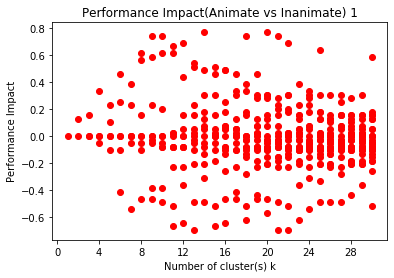

In [9]:
from matplotlib.ticker import MaxNLocator
f = 1
clf_result = result[f]


fig = plt.figure(1)
X = range(1,31,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact")
plt.title('Performance Impact(Animate vs Inanimate) '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.eps', format='eps')

In [ ]:
f = 2
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 3
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 4
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

In [ ]:
#Smooth average graph
from scipy.interpolate import spline
noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.png', format='png', dpi=200)
print(max(Y), Y.index(max(Y)) + 1)